In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import casadi as ca
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel

In [2]:
class OptimizationDemo:
    def __init__(self):

        self.func_flag = 'quadratic'

        self.x_init = np.array([0.0, 0.0])

        self.solution_trajectory = []
        self.directions = []

        self.x = ca.MX.sym('x', 2)
        
        # Hyperparameters for line search
        self.alpha_0 = 1.0
        self.beta = 0.5
        self.c = 1e-4

    def set_objective(self, func_type='quadratic'):
        self.func_flag = func_type

        if func_type == 'quadratic':
            expr = 0.5 * (self.x[0]**2/4 + self.x[1]**2)
            self.global_minima = np.array([0.0, 0.0])

        elif func_type == 'rosenbrock':
            expr = (1 - self.x[0])**2 + 100*(self.x[1] - self.x[0]**2)**2
            self.global_minima = np.array([1.0, 1.0])

        elif func_type == 'rastrigin':
            expr = 20 + (self.x[0]**2 - 10*ca.cos(2*np.pi*self.x[0])) + (self.x[1]**2 - 10*ca.cos(2*np.pi*self.x[1]))
            self.global_minima = np.array([0.0, 0.0])

        else:
            raise ValueError("Unknown function type.")

        self.expr = expr
        self.f = ca.Function('f', [self.x], [expr])
        self.grad_f = ca.Function('grad_f', [self.x], [ca.gradient(expr, self.x)])
        self.hess_f = ca.Function('hess_f', [self.x], [ca.hessian(expr, self.x)[0]])

    def solve(self, x_init, method='gd', max_step=100, tol=1e-6):

        self.x_init = np.array(x_init, dtype=np.float64)
        self.method = method
        self.tol = tol
        self.max_step = max_step

        self.solution_trajectory = [self.x_init.copy()]
        self.directions = []

        # Unconstrained optimization
        x_val = np.copy(self.x_init)

        for _ in range(self.max_step):
            grad = self.grad_f(x_val).full().flatten()
            hess = self.hess_f(x_val).full()

            # Search direction
            if self.method == 'gd':
                direction = -grad
            elif self.method == 'newton':
                direction = -np.linalg.solve(hess + 1e-8*np.eye(2), grad)
            else:
                raise ValueError("Method must be 'gd' or 'newton'")

            descent = grad @ direction
            if abs(descent) < self.tol:
                break

            # Line search (backtracking)
            alpha = self.alpha_0
            f0 = float(self.f(x_val))
            while float(self.f(x_val + alpha * direction)) > f0 + self.c * alpha * descent:
                alpha *= self.beta
            
            # Update
            x_val = x_val + alpha * direction
            self.solution_trajectory.append(x_val.copy())
            self.directions.append(direction.copy())

    def plot_results(self):

        sol = np.array(self.solution_trajectory)

        x_max = max(5, np.max(sol[:,0]))
        x_min = min(-5, np.min(sol[:,0]))
        y_max = max(5, np.max(sol[:,1]))
        y_min = min(-5, np.min(sol[:,1]))

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        fig, ax = plt.subplots(figsize=(10,8))
        
        # Plot global optima
        ax.plot(self.global_minima[0], self.global_minima[1], marker='*', markersize=15, color='red', label='Global Optima')
        
        '''
        # Plot equality constraint (if have)
        if self.constraint_flag['equality']:

            x1 = ca.MX.sym('x1')  
            x0 = ca.MX.sym('x0') 
            x_sub = ca.vertcat(x0, x1)
            g_substituted = ca.substitute(self.g, self.x, x_sub)

            g_func = ca.Function('g_func', [x1, x0], [g_substituted])
            solver = ca.rootfinder('solver', 'newton', g_func)

            x_vals = x
            x_list = []
            y_list = []

            for xi in x_vals:
                try:
                    y_sol = solver(0.0, xi) 
                    yi = float(y_sol)
 
                    if x_min <= xi <= x_max and y_min <= yi <= y_max:
                        x_list.append(xi)
                        y_list.append(yi)
                except RuntimeError:
                    continue

            x_list = np.array(x_list)
            y_list = np.array(y_list)
            
            if len(x_list) > 0:
                ax.plot(x_list, y_list, label='Equality Constraint Curve')
        '''

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i,j] = self.f(np.array([X[i,j], Y[i,j]])).full().flatten()[0]

        CS = ax.contour(X, Y, Z, levels=50, cmap=cm.viridis)
        ax.clabel(CS, inline=True, fontsize=8)

        ax.plot(sol[:,0], sol[:,1], marker='o', markersize=4, color='orange', label='Trajectory')
        ax.plot(sol[0,0], sol[0,1], 'bo', label='Start')
        ax.plot(sol[-1,0], sol[-1,1], 'gs', label='End')

        ax.set_title(f'Optimization Trajectory with {self.func_flag.capitalize()} Function')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend()
        plt.grid(True)
        plt.show()

Unconstrained case: 

key idea: 
1) GD for quadratic (performance baseline)
2) GD for rosenbrock (limitation of GD)
3) Newton for rosenbrock (Newton outperform GD in searching direction)
4) GD & Newton for Rastrigin (limitation of non-convex function -> only local attractive)

cost: quadratic + Rosenbrock + Rastrigin

method: hand written GD/Newton + line search

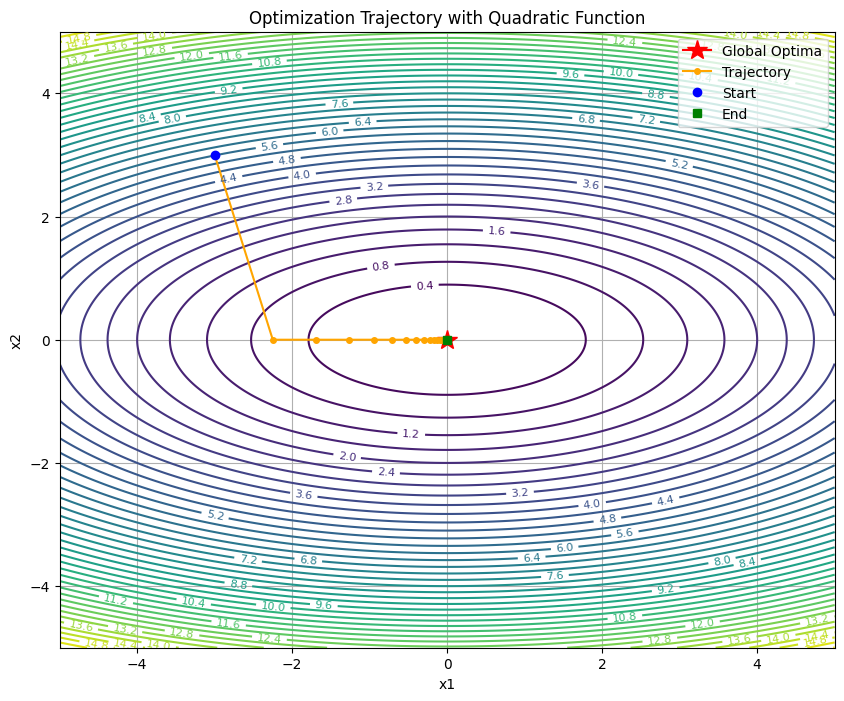

In [3]:
# Quadratic cost + GD solver
opt = OptimizationDemo()
opt.set_objective('quadratic')
opt.solve(x_init=[-3, 3], method='gd', max_step=100)
opt.plot_results()


Conclusion: for simple case (quadratic -> convex), GD is able to find global optima and quite fast

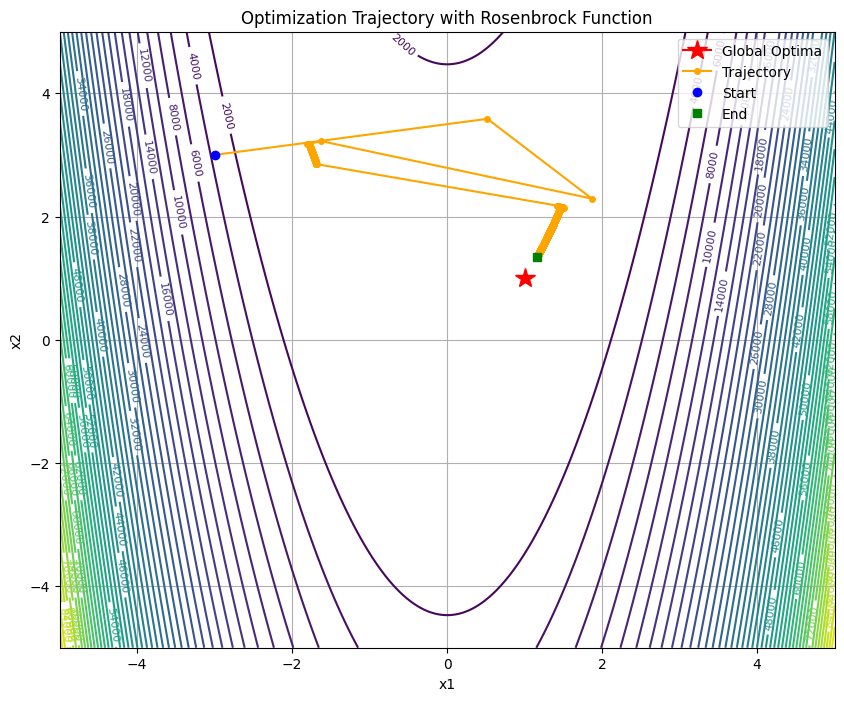

In [4]:
# Rosenbrock cost + GD solver
opt = OptimizationDemo()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3.0, 3.0], method='gd', max_step=3000) 
opt.plot_results()

Conclusion: for complexer case (Rosenbrock->ill-conditioning), GD is still able to find the global optima, but 3000~5000 steps & zig-zag

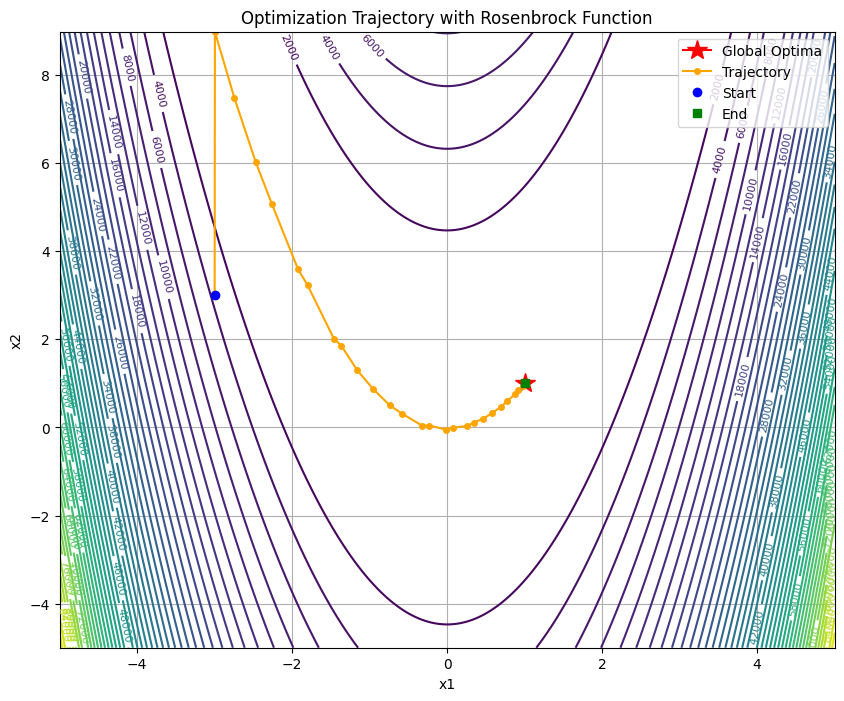

In [5]:
# Rosenbrock cost + newton solver
opt = OptimizationDemo()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3, 3], method='newton', max_step=100)
opt.plot_results()


Conclusion: able to find the global optima & much faster that GD (<100 steps)   
Deeper insight: more info (in coop. with curvature information)

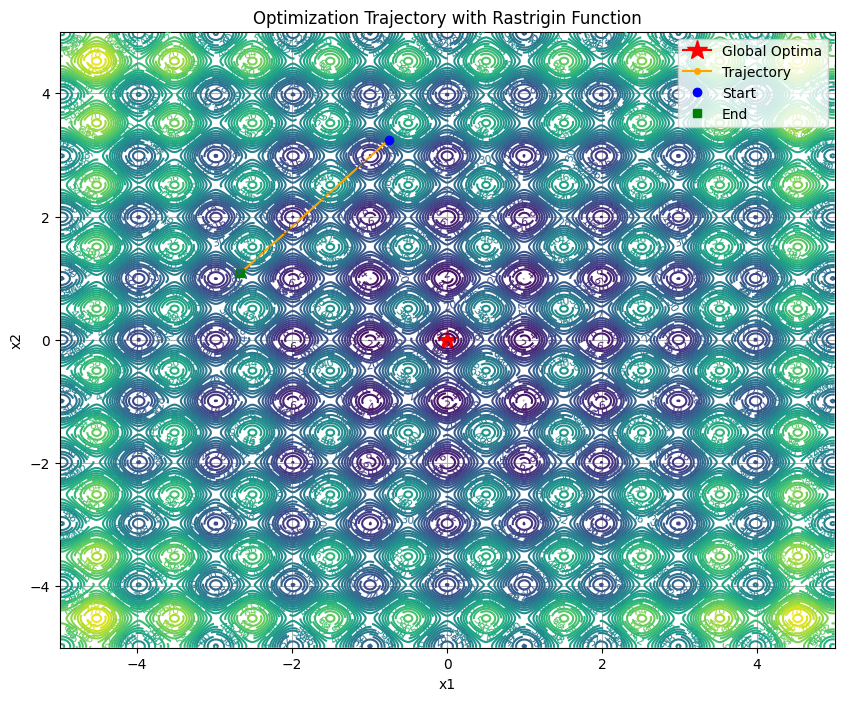

In [6]:
# Rastrigin cost + newton solver
opt = OptimizationDemo()
opt.set_objective('rastrigin')
opt.solve(x_init=[-0.75, 3.25], method='newton', max_step=1000) # [-0.75, 3.25] OR [-0.25, 0.25]
opt.plot_results()

Constrained case:

key idea: 

1) lagrangian (linear equality constr)
2) KKT & QP (linear inequality constr)
3) SQP (nonlinear inequality constr)

cost: quadratic

constr: linear / nonlinear equality / inequality constr

solver: IPOPT or Acados


In [7]:
# Quadratic cost + Equality constraint: Lagrangian